In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Check Libriraires 

In [2]:
pip install tensorflow-text==2.6.0-dev20210407


ERROR: Could not find a version that satisfies the requirement tensorflow-text==2.6.0-dev20210407 (from versions: 0.1.0, 1.0.0b0, 1.0.0b1, 1.15.0rc0, 1.15.0, 1.15.1, 2.0.0rc0, 2.0.0, 2.0.1, 2.1.0rc0, 2.1.1, 2.2.0rc1, 2.2.0rc2, 2.2.0, 2.2.1, 2.3.0rc1, 2.3.0, 2.4.0b0, 2.4.0rc0, 2.4.0rc1, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.5.0, 2.6.0rc0, 2.6.0, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.3, 2.8.0rc0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0, 2.10.0b2)
ERROR: No matching distribution found for tensorflow-text==2.6.0-dev20210407
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade tensorflow-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 37.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 23.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: protobuf
    Found exist

## Imports

In [12]:
# Imports
import cv2
import os
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

## Loading Dataset

In [13]:
df = pd.read_csv("../input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [14]:
# Group bt Drivers/ Test Subjects
by_drivers = df.groupby('subject')

unique_drivers = by_drivers.groups.keys()

print("There are: ", len(unique_drivers), " unique drivers")
print('There is a mean of ',round(by_drivers.count()['classname']), ' images by driver.')

There are:  26  unique drivers
There is a mean of  subject
p002     725
p012     823
p014     876
p015     875
p016    1078
p021    1237
p022    1233
p024    1226
p026    1196
p035     848
p039     651
p041     605
p042     591
p045     724
p047     835
p049    1011
p050     790
p051     920
p052     740
p056     794
p061     809
p064     820
p066    1034
p072     346
p075     814
p081     823
Name: classname, dtype: int64  images by driver.


In [15]:
NUMBER_CLASSES = 10

In [16]:
# Read with opencv
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
    Function that return an opencv image from the path and the right number of dimension
    """
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

# Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    """
    Return train images and train labels from the original path
    """
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
    Load + categorical + split
    """
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10) #categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [17]:
# dimension of images
img_rows = 128 
img_cols = 128

color_type = 1 # grey
nb_test_samples = 200

In [9]:
# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


  0%|          | 0/10 [00:06<?, ?it/s]


KeyboardInterrupt: 

## EDA

In [ ]:
x_train_size = len(x_train)
x_test_size = len(x_test)
test_files_size = len(np.array(glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg'))))

> ## Statistical numbers about the data

In [ ]:
print('There are %s total images.' %(x_train_size + x_test_size + test_files_size))
print('There are %d total training categories.' %NUMBER_CLASSES )
print('There are %d training images.' % x_train_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

> ## Data Visulization

In [11]:
import plotly.express as px

px.histogram(df, x="classname", color="classname", title="Number of images by categories ")

In [12]:
# Number of Images by Drivers / Test Subject

In [13]:
# np.save('./x_train.npy',x_train)
# np.save('./y_train.npy',y_train)
# np.save('./x_test.npy',x_test)
# np.save('./y_test.npy',y_test)

# Fully connected layer

## Fill this to continue running smoothly, I think

In [18]:
# x_train = np.load('../input/dl-project/x_train.npy').astype('float32')/255
# y_train = np_utils.to_categorical(np.load('../input/dl-project/y_train.npy'))
# x_val = np.load('../input/dl-project/x_test.npy').astype('float32')/255
# y_val = np_utils.to_categorical(np.load('../input/dl-project/y_test.npy'))
no_epoch = 5
batch_size = 64
img_height = img_rows
img_width = img_cols
channels = 1

In [17]:
# x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)/255
# y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
# x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)/255
# y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

## Building initial model

In [18]:
# temp
x_train_FC = x_train.reshape((x_train_size, img_rows*img_cols*1))
x_train_FC = x_train_FC.astype('float32')/255
x_val_FC = x_test.reshape((x_test_size, img_rows*img_cols*1))
x_val_FC = x_val_FC.astype('float32')/255
y_val = y_test

In [19]:
FC_init = Sequential()
# FC_init.add(Flatten())
FC_init.add(Dense(512, activation='relu', name='Layer_1', input_shape=(img_width * img_height * channels,)))
FC_init.add(Dense(256, activation='relu', name='Layer_2'))
FC_init.add(Dense(128, activation='relu', name='Layer_3'))
FC_init.add(Dense(10, activation='softmax'))

In [20]:
opt = keras.optimizers.Adam(learning_rate=10e-3)
FC_init.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [21]:
FC_init.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (Dense)             (None, 512)               8389120   
                                                                 
 Layer_2 (Dense)             (None, 256)               131328    
                                                                 
 Layer_3 (Dense)             (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 8,554,634
Trainable params: 8,554,634
Non-trainable params: 0
_________________________________________________________________


In [19]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

In [23]:
History = FC_init.fit(x_train_FC,y_train, validation_data=(x_val_FC,y_val), verbose = 1, epochs = no_epoch, batch_size = batch_size,callbacks=[early_stopping])

2022-07-08 12:46:03.936670: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1175650304 exceeds 10% of free system memory.
2022-07-08 12:46:05.161203: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1175650304 exceeds 10% of free system memory.


Epoch 1/5
276/281 [============================>.] - ETA: 0s - loss: 5.8255 - accuracy: 0.1842

2022-07-08 12:46:08.780301: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 293928960 exceeds 10% of free system memory.
2022-07-08 12:46:09.115535: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 293928960 exceeds 10% of free system memory.


281/281 [==============================] - 4s 9ms/step - loss: 5.7659 - accuracy: 0.1851 - val_loss: 2.1087 - val_accuracy: 0.2069
Epoch 2/5
281/281 [==============================] - 2s 8ms/step - loss: 1.7307 - accuracy: 0.3284 - val_loss: 1.5923 - val_accuracy: 0.3920
Epoch 3/5
281/281 [==============================] - 2s 6ms/step - loss: 1.3789 - accuracy: 0.4724 - val_loss: 1.2814 - val_accuracy: 0.5142
Epoch 4/5
281/281 [==============================] - 2s 6ms/step - loss: 1.1718 - accuracy: 0.5632 - val_loss: 1.0644 - val_accuracy: 0.5904
Epoch 5/5
281/281 [==============================] - 2s 6ms/step - loss: 0.9568 - accuracy: 0.6537 - val_loss: 1.2426 - val_accuracy: 0.5474


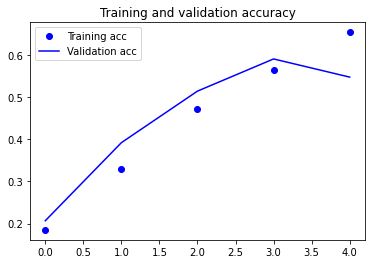

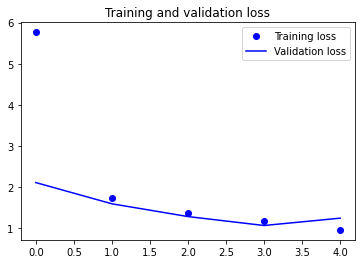

In [24]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predict 

In [25]:
test_files.dtype

dtype('uint8')

In [26]:
test_files[0].shape

(128, 128, 1)

In [27]:
x_train.dtype

dtype('uint8')

In [28]:
print(len(test_files))
print(test_files_size)


200
79726


In [29]:
test_imgs = test_files.reshape((nb_test_samples, img_rows*img_cols*1))
test_imgs = test_imgs.astype('float32')/255


In [30]:
pred = FC_init.predict(test_imgs)
pred[0]

7/7 [==============================] - 0s 3ms/step


array([8.09583678e-10, 2.48083581e-10, 6.38833639e-11, 1.81621763e-05,
       1.13807124e-04, 9.99598324e-01, 2.63856316e-04, 5.82128951e-06,
       1.27073861e-07, 7.47056816e-09], dtype=float32)

In [31]:
FC_init.evaluate(test_imgs, pred)

7/7 [==============================] - 0s 4ms/step - loss: 0.9791 - accuracy: 1.0000


[0.979055643081665, 1.0]

### Evaluate the model

## Building Baseline CNN Model

In [20]:
# temp
x_train_CNN = x_train.reshape((x_train_size, img_rows,img_cols,1))
x_train_CNN = x_train_CNN.astype('float32')/255
x_val_CNN = x_test.reshape((x_test_size, img_rows,img_cols,1))
x_val_CNN = x_val_CNN.astype('float32')/255
y_val = y_test

NameError: name 'x_train' is not defined

In [17]:
CNN_model = Sequential()
CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(10, activation='softmax'))


2022-07-08 13:19:51.720287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 13:19:51.725368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 13:19:51.726263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 13:19:51.728128: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
CNN_model.compile(optimizer="rmsprop",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [20]:
History_CNN = CNN_model.fit(x_train_CNN,y_train, validation_data=(x_val_CNN,y_val), verbose = 1, epochs = no_epoch, batch_size = batch_size,callbacks=[early_stopping])

2022-07-08 13:20:28.029073: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1175650304 exceeds 10% of free system memory.
2022-07-08 13:20:29.300992: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1175650304 exceeds 10% of free system memory.
2022-07-08 13:20:30.251913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-07-08 13:20:31.989263: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


281/281 [==============================] - 15s 23ms/step - loss: 0.7602 - accuracy: 0.7615 - val_loss: 0.1914 - val_accuracy: 0.9445
Epoch 2/5
281/281 [==============================] - 6s 20ms/step - loss: 0.0617 - accuracy: 0.9825 - val_loss: 0.0539 - val_accuracy: 0.9866
Epoch 3/5
281/281 [==============================] - 6s 20ms/step - loss: 0.0212 - accuracy: 0.9936 - val_loss: 0.1687 - val_accuracy: 0.9612
Epoch 4/5
281/281 [==============================] - 6s 21ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.0284 - val_accuracy: 0.9926
Epoch 5/5
281/281 [==============================] - 6s 20ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.0628 - val_accuracy: 0.9875


In [ ]:
acc = History_CNN.history['accuracy']
val_acc = History_CNN.history['val_accuracy']
loss = History_CNN.history['loss']
val_loss = History_CNN.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_imgs = test_files.reshape((nb_test_samples, img_rows,img_cols,1))
test_imgs = test_imgs.astype('float32')/255


In [ ]:
pred = CNN_model.predict(test_imgs)
pred[0]

## Data Augmentation

In [21]:
Traindatagen = ImageDataGenerator(
      featurewise_center = True,
      featurewise_std_normalization = True,
      rescale = 1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=False,
      fill_mode='nearest')


Valdatagen =  ImageDataGenerator(featurewise_center = True, 
                                 featurewise_std_normalization = True, 
                                 rescale=1.0/ 255, 
                                 validation_split = 0.2)

In [8]:
train_generator = Traindatagen.flow(x_train_CNN, y_train, batch_size = 256)
val_generator = Valdatagen.flow(x_val_CNN, y_val, batch_size = 64)

NameError: name 'x_train_CNN' is not defined

# Transfer learning using resnet-rs

In [22]:
# loading train images
x_train_rs, x_test_rs, y_train_rs, y_test_rs = read_and_normalize_train_data(img_rows, img_cols, 3)

# loading validation images
# test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, 3)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:26<03:57, 26.37s/it]

Loading directory c1


 20%|██        | 2/10 [00:50<03:20, 25.04s/it]

Loading directory c2


 30%|███       | 3/10 [01:15<02:54, 24.90s/it]

Loading directory c3


 40%|████      | 4/10 [01:40<02:29, 24.90s/it]

Loading directory c4


 50%|█████     | 5/10 [02:05<02:04, 24.91s/it]

Loading directory c5


 60%|██████    | 6/10 [02:29<01:39, 24.76s/it]

Loading directory c6


 70%|███████   | 7/10 [02:54<01:14, 24.76s/it]

Loading directory c7


 80%|████████  | 8/10 [03:15<00:47, 23.64s/it]

Loading directory c8


 90%|█████████ | 9/10 [03:35<00:22, 22.50s/it]

Loading directory c9


100%|██████████| 10/10 [03:58<00:00, 23.82s/it]


In [23]:
train_generator = Traindatagen.flow(x_train_rs, y_train_rs, batch_size = 256)
val_generator = Valdatagen.flow(x_test_rs, y_test_rs, batch_size = 64)

In [24]:
# resnet_rs50_conv_base = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(128,128,3))

from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

2022-07-08 14:19:27.036884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:19:27.160127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:19:27.160900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:19:27.162605: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 1s 0us/step


In [26]:
# resnet_rs50_conv_base.trainable = False
conv_base.trainable = False

In [27]:
resnetRs = Sequential()
# resnetRs.add(resnet_rs50_conv_base)
resnetRs.add(conv_base)
resnetRs.add(Flatten())
resnetRs.add(Dense(256, activation='relu'))
resnetRs.add(Dense(10, activation='softmax'))

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
resnetRs.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [29]:
epochs = 5
train_bs = 256
valdi_bs = 64

In [30]:
History_Rs = resnetRs.fit(train_generator,
         validation_data=val_generator,
         steps_per_epoch=len(x_train_rs) // train_bs, epochs=epochs,
          validation_steps =len(x_test_rs)//valdi_bs, verbose = 1)


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2022-07-08 14:24:22.482156: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-07-08 14:24:24.953716: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


70/70 [==============================] - 86s 1s/step - loss: 2.9301 - accuracy: 0.2015 - val_loss: 1.7648 - val_accuracy: 0.4103
Epoch 2/5
70/70 [==============================] - 70s 1s/step - loss: 1.8666 - accuracy: 0.3591 - val_loss: 1.3904 - val_accuracy: 0.5069
Epoch 3/5
70/70 [==============================] - 68s 977ms/step - loss: 1.6378 - accuracy: 0.4443 - val_loss: 1.2269 - val_accuracy: 0.5690
Epoch 4/5
70/70 [==============================] - 70s 995ms/step - loss: 1.4725 - accuracy: 0.5043 - val_loss: 1.0186 - val_accuracy: 0.6848
Epoch 5/5
70/70 [==============================] - 70s 995ms/step - loss: 1.3169 - accuracy: 0.5586 - val_loss: 1.0869 - val_accuracy: 0.6580


In [31]:
History_Rs_2 = resnetRs.fit(train_generator,
         validation_data=val_generator,
         steps_per_epoch=len(x_train_rs) // train_bs, epochs=10,
          validation_steps =len(x_test_rs)//valdi_bs, verbose = 1)

Epoch 1/10
70/70 [==============================] - 68s 971ms/step - loss: 1.2172 - accuracy: 0.5882 - val_loss: 0.8295 - val_accuracy: 0.7400
Epoch 2/10
70/70 [==============================] - 70s 1s/step - loss: 1.1337 - accuracy: 0.6190 - val_loss: 1.1271 - val_accuracy: 0.6246
Epoch 3/10
70/70 [==============================] - 71s 1s/step - loss: 1.0644 - accuracy: 0.6447 - val_loss: 0.5820 - val_accuracy: 0.8147
Epoch 4/10
70/70 [==============================] - 70s 994ms/step - loss: 1.0138 - accuracy: 0.6600 - val_loss: 0.7136 - val_accuracy: 0.7587
Epoch 5/10
70/70 [==============================] - 71s 1s/step - loss: 0.9866 - accuracy: 0.6718 - val_loss: 0.5927 - val_accuracy: 0.7891
Epoch 6/10
70/70 [==============================] - 69s 985ms/step - loss: 0.9428 - accuracy: 0.6832 - val_loss: 0.5918 - val_accuracy: 0.7944
Epoch 7/10
70/70 [==============================] - 70s 998ms/step - loss: 0.9139 - accuracy: 0.6932 - val_loss: 0.6582 - val_accuracy: 0.7565
Epoch 8/

In [33]:
resnetRs.save('./my_model.h5')

In [34]:
new_model = tf.keras.models.load_model('./my_model.h5')

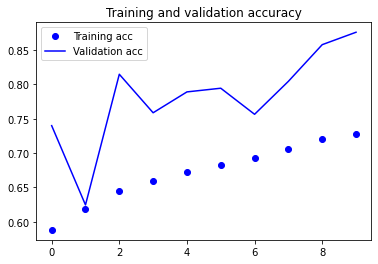

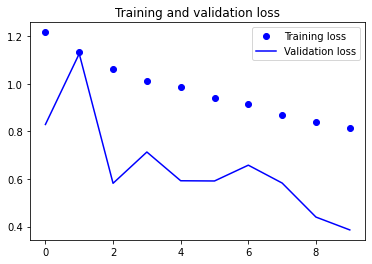

In [32]:
acc = History_Rs_2.history['accuracy']
val_acc = History_Rs_2.history['val_accuracy']
loss = History_Rs_2.history['loss']
val_loss = History_Rs_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()